# Klasifikasi Kesehatan dari Parameter BPM, SPO2 dan Suhu Tubuh

## Membaca File CSV

Termasuk menghapus kolom yang isinya NAN dan melakukan pengolahan data

In [1]:
import pandas as bacafile, numpy as konversifloat
from sklearn.model_selection import train_test_split

train_test_ratio = 0.9
train_valid_ratio = 0.9

mentah = bacafile.read_csv("/content/gdrive/My Drive/Data_BPM_SPO2_dan_Suhu_Tubuh.csv",dtype=konversifloat.float64)
## mentah[['Heartrate (BPM)','SpO2 (%)','Body Temperature (C)','Jumlah Parameter Tidak Normal']] = mentah[['Heartrate (BPM)','SpO2 (%)','Body Temperature (C)','Jumlah Parameter Tidak Normal']].apply(bacafile.to_numeric)
mentah.drop(['Unnamed: 0'],axis=1,inplace=True)
mentah['label']=0.0;
## mentah = mentah[['label','Heartrate (BPM)',' SpO2 (%)','Body Temperature (C)','Jumlah Parameter Tidak Normal']]
for _, row in mentah.iterrows():
  row['label'] = (1 if row['Jumlah Parameter Tidak Normal']<2 else 0)
olahmentah = mentah.rename(columns={'Heartrate (BPM)': 'Heartrate (BPM)',' SpO2 (%)': 'SpO2 (%)','Body Temperature (C)': 'Body Temperature (C)','Jumlah Parameter Tidak Normal': 'UnNormal','label': 'label'})
olahmentah

,Heartrate (BPM),SpO2 (%),Body Temperature (C),UnNormal,label
0,93.0,96.0,37.1,0.0,1.0
1,93.0,96.0,37.1,0.0,1.0
2,93.0,96.0,37.1,0.0,1.0
3,93.0,96.0,37.1,0.0,1.0
4,93.0,96.0,37.1,0.0,1.0
...,...,...,...,...,...
59996,91.0,94.0,37.7,1.0,1.0
59997,91.0,94.0,39.1,1.0,1.0
59998,91.0,94.0,39.1,1.0,1.0
59999,91.0,94.0,38.5,1.0,1.0


## Pembagian Data untuk Testing, Training dan Validasi

In [2]:
df_normal = olahmentah[olahmentah['label'] == 1]
df_unnormal = olahmentah[olahmentah['label'] == 0]

# Train-test split
df_normal_full_train, df_normal_test = train_test_split(df_normal, train_size = train_test_ratio, random_state = 1)
df_unnormal_full_train, df_unnormal_test = train_test_split(df_unnormal, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_normal_train, df_normal_valid = train_test_split(df_normal_full_train, train_size = train_valid_ratio, random_state = 1)
df_unnormal_train, df_unnormal_valid = train_test_split(df_unnormal_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = bacafile.concat([df_normal_train, df_unnormal_train], ignore_index=True, sort=False)
df_valid = bacafile.concat([df_normal_valid, df_unnormal_valid], ignore_index=True, sort=False)
df_test = bacafile.concat([df_normal_test, df_unnormal_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv('/content/gdrive/My Drive/BPM_SPO2_Body_Temperature/train.csv', index=False)
df_valid.to_csv('/content/gdrive/My Drive/BPM_SPO2_Body_Temperature/valid.csv', index=False)
df_test.to_csv('/content/gdrive/My Drive/BPM_SPO2_Body_Temperature/test.csv', index=False)

# (Prediksi) Klasifikasi dengan LSTM

## Menyiapkan Library yang Diperlukan untuk Klasifikasi

In [3]:
# Libraries

import matplotlib.pyplot as sumbuplot
import torch

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as modelgraph
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optimasi_algoritma

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as representasi_statistik

## Loading dari Dataset yang Ada untuk Testing, Training dan Validasi

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('UnNormal', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path='/content/gdrive/My Drive/BPM_SPO2_Body_Temperature/', train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.UnNormal),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.UnNormal),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.UnNormal),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

## Tahapan Pembangunan Modelling

In [5]:
class LSTM(modelgraph.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = modelgraph.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = modelgraph.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = modelgraph.Dropout(p=0.5)

        self.fc = modelgraph.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

## Tahapan Training

Bangun dulu fungsi checkpoint, serta save dan load dataset

In [6]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

Bangun Fungsi Training dan Menjalankan Training

In [7]:
# Training Function

def train(model,
          optimizer,
          criterion = modelgraph.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = '/content/gdrive/My Drive/BPM_SPO2_Body_Temperature',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len)), _ in train_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (text, text_len)), _ in valid_loader:
                      labels = labels.to(device)
                      text = text.to(device)
                      text_len = text_len.to(device)
                      output = model(text, text_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optimasi_algoritma.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [759/15190], Train Loss: -8369.9103, Valid Loss: -9100.4236
Model saved to ==> /content/gdrive/My Drive/BPM_SPO2_Body_Temperature/model.pt
Model saved to ==> /content/gdrive/My Drive/BPM_SPO2_Body_Temperature/metrics.pt
Epoch [1/10], Step [1518/15190], Train Loss: -9101.6936, Valid Loss: -9125.9749
Model saved to ==> /content/gdrive/My Drive/BPM_SPO2_Body_Temperature/model.pt
Model saved to ==> /content/gdrive/My Drive/BPM_SPO2_Body_Temperature/metrics.pt
Epoch [2/10], Step [2277/15190], Train Loss: -9132.6071, Valid Loss: -9125.9749
Epoch [2/10], Step [3036/15190], Train Loss: -9119.8761, Valid Loss: -9125.9749
Epoch [3/10], Step [3795/15190], Train Loss: -9132.6130, Valid Loss: -9125.9749
Epoch [3/10], Step [4554/15190], Train Loss: -9120.6343, Valid Loss: -9125.9749
Epoch [4/10], Step [5313/15190], Train Loss: -9131.8637, Valid Loss: -9125.9749
Epoch [4/10], Step [6072/15190], Train Loss: -9121.2080, Valid Loss: -9125.9749
Epoch [5/10], Step [6831/15190], Train Lo

Menampilkan Hasil Training dan Validasi

Model loaded from <== /content/gdrive/My Drive/BPM_SPO2_Body_Temperature/metrics.pt


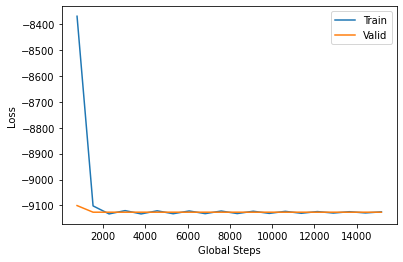

In [8]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('/content/gdrive/My Drive/BPM_SPO2_Body_Temperature/metrics.pt')
sumbuplot.plot(global_steps_list, train_loss_list, label='Train')
sumbuplot.plot(global_steps_list, valid_loss_list, label='Valid')
sumbuplot.xlabel('Global Steps')
sumbuplot.ylabel('Loss')
sumbuplot.legend()
sumbuplot.show() 

## Tahapan Evaluasi

In [9]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= sumbuplot.subplot()
    representasi_statistik.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Normal', 'Perlu Pemeriksaan Lanjut'])
    ax.yaxis.set_ticklabels(['Normal', 'Perlu Pemeriksaan Lanjut'])
    
    
best_model = LSTM().to(device)
optimizer = optimasi_algoritma.Adam(best_model.parameters(), lr=0.001)

load_checkpoint('/content/gdrive/My Drive/BPM_SPO2_Body_Temperature/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

Model loaded from <== /content/gdrive/My Drive/BPM_SPO2_Body_Temperature/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       0.0
           0     0.0000    0.0000    0.0000       0.0

   micro avg     0.0000    0.0000    0.0000       0.0
   macro avg     0.0000    0.0000    0.0000       0.0
weighted avg     0.0000    0.0000    0.0000       0.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: ignored

## Prediksi

Fungsi Prediksi

In [10]:
#inference 
import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [text_field.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction 
    return prediction.item()

In [11]:
listprediksi = mentah.rename(columns={'Heartrate (BPM)': 'Heartrate (BPM)',' SpO2 (%)': 'SpO2 (%)','Body Temperature (C)': 'Body Temperature (C)','Jumlah Parameter Tidak Normal': 'Jumlah Parameter Tidak Normal','label': 'label'})
listprediksi['Kondisi Kesehatan'] = ""; listprediksi['Keadaan Jantung']=""; listprediksi['Keadaan Paru-Paru']=""; listprediksi['Keadaan Regulasi Tubuh']="";
nilaiprediksi = []; klasifikasi = []; heartcheck = []; lungcheck = []; bodycheck = [];
for _, row in listprediksi.iterrows():
  simpanprediksi = predict(best_model, "row['Jumlah Parameter Tidak Normal']")
  nilaiprediksi.append(simpanprediksi)
  if (row['Jumlah Parameter Tidak Normal'] >= 2 or (row['Heartrate (BPM)'] < 60 or row['Heartrate (BPM)'] > 100) or (row['SpO2 (%)'] < 90) or (row['Body Temperature (C)'] > 38) ): klasifikasi.append("Perlu Pemeriksaan Lanjut")
  else: klasifikasi.append("Kesehatan Normal")
  ## Jantung
  if (row['Heartrate (BPM)'] >= 49 and row['Heartrate (BPM)'] < 60): heartcheck.append("Masih dalam Batas Wajar")
  elif (row['Heartrate (BPM)'] >= 60 and row['Heartrate (BPM)'] < 66): heartcheck.append("Sangat Baik")
  elif (row['Heartrate (BPM)'] >= 66 and row['Heartrate (BPM)'] < 75): heartcheck.append("Cukup Baik")
  elif (row['Heartrate (BPM)'] >= 75 and row['Heartrate (BPM)'] < 90): heartcheck.append("Perlu Diperhatikan")
  elif (row['Heartrate (BPM)'] >= 90 and row['Heartrate (BPM)'] < 100): heartcheck.append("Waspada")
  else: heartcheck.append("Perlu Pemeriksaan Lanjut")
  ## Paru-Paru / Kadar Oksigen Dalam Darah
  if (row['SpO2 (%)'] >= 95 and row['SpO2 (%)'] <= 100): lungcheck.append("Sangat Baik")
  elif (row['SpO2 (%)'] >= 92 and row['SpO2 (%)'] < 95): lungcheck.append("Perlu Diperhatikan")
  elif (row['SpO2 (%)'] >= 90 and row['SpO2 (%)'] < 92): lungcheck.append("Waspada")
  else: lungcheck.append("Perlu Pemeriksaan / Tindak Lanjut")
  ## Suhu Tubuh (Keadaan Regulasi Tubuh)
  if (row['Body Temperature (C)'] >= 35 and row['Body Temperature (C)'] < 37): bodycheck.append("Sangat Baik")
  elif (row['Body Temperature (C)'] >= 37 and row['Body Temperature (C)'] < 37.5): bodycheck.append("Cukup Baik")
  elif (row['Body Temperature (C)'] >= 37.5 and row['Body Temperature (C)'] <= 38): bodycheck.append("Perlu Diperhatikan")
  else: bodycheck.append("Perlu Pemeriksaan / Tindak Lanjut")
listprediksi['nilai prediksi'] = nilaiprediksi; listprediksi['Kondisi Kesehatan'] = klasifikasi; listprediksi['Keadaan Jantung']= heartcheck; listprediksi['Keadaan Paru-Paru']= lungcheck; listprediksi['Keadaan Regulasi Tubuh']= bodycheck;
listprediksi

,Heartrate (BPM),SpO2 (%),Body Temperature (C),Jumlah Parameter Tidak Normal,label,Kondisi Kesehatan,Keadaan Jantung,Keadaan Paru-Paru,Keadaan Regulasi Tubuh,nilai prediksi
0,93.0,96.0,37.1,0.0,1.0,Kesehatan Normal,Waspada,Sangat Baik,Cukup Baik,0.999181
1,93.0,96.0,37.1,0.0,1.0,Kesehatan Normal,Waspada,Sangat Baik,Cukup Baik,0.999181
2,93.0,96.0,37.1,0.0,1.0,Kesehatan Normal,Waspada,Sangat Baik,Cukup Baik,0.999181
3,93.0,96.0,37.1,0.0,1.0,Kesehatan Normal,Waspada,Sangat Baik,Cukup Baik,0.999181
4,93.0,96.0,37.1,0.0,1.0,Kesehatan Normal,Waspada,Sangat Baik,Cukup Baik,0.999181
...,...,...,...,...,...,...,...,...,...,...
59996,91.0,94.0,37.7,1.0,1.0,Kesehatan Normal,Waspada,Perlu Diperhatikan,Perlu Diperhatikan,0.999181
59997,91.0,94.0,39.1,1.0,1.0,Perlu Pemeriksaan Lanjut,Waspada,Perlu Diperhatikan,Perlu Pemeriksaan / Tindak Lanjut,0.999181
59998,91.0,94.0,39.1,1.0,1.0,Perlu Pemeriksaan Lanjut,Waspada,Perlu Diperhatikan,Perlu Pemeriksaan / Tindak Lanjut,0.999181
59999,91.0,94.0,38.5,1.0,1.0,Perlu Pemeriksaan Lanjut,Waspada,Perlu Diperhatikan,Perlu Pemeriksaan / Tindak Lanjut,0.999181


Export ke CSV

In [12]:
listprediksi.to_csv("/content/gdrive/My Drive/BPM_SPO2_Body_Temperature/hasil_klasifikasi.csv")